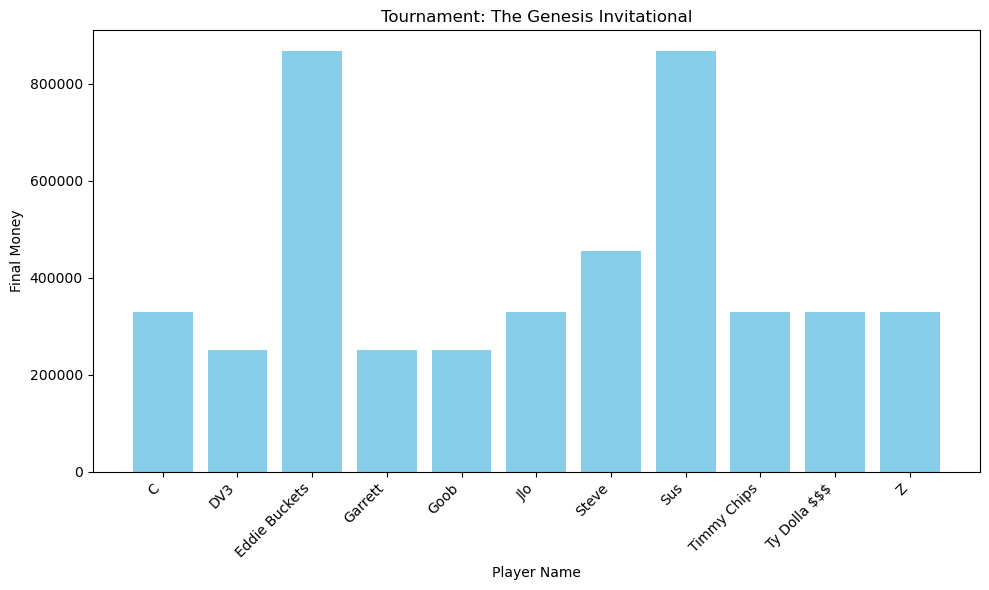

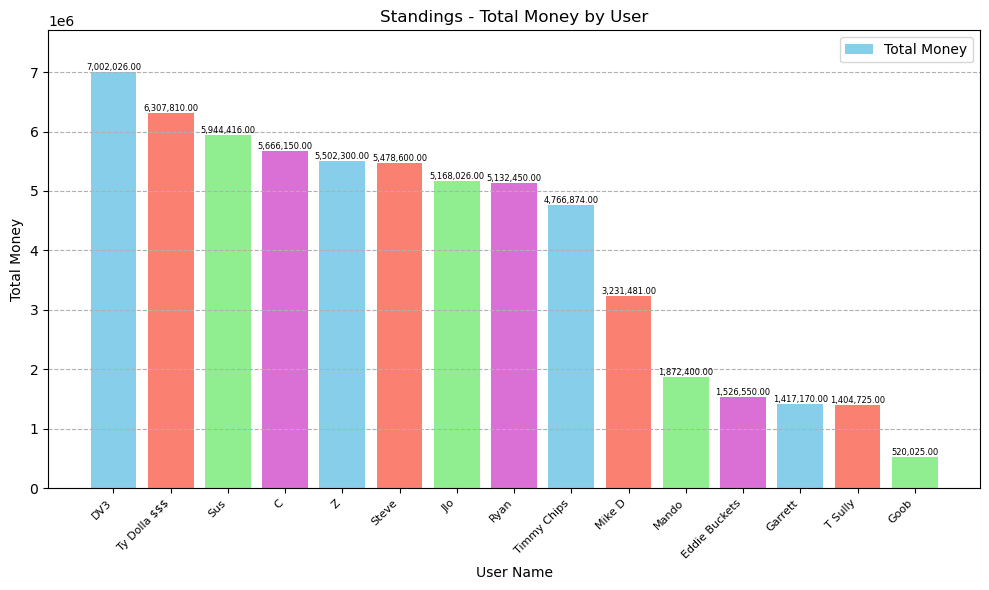

In [34]:
import tkinter as tk
from tkinter import ttk
import psycopg2
import pandas as pd
import sqlite3 
from tkinter import messagebox
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt

db_creds = pd.read_csv('/users/zack burnside/desktop/database_creds.csv')

tournament_data = pd.read_csv('/users/zack burnside/desktop/tournament_info.csv')
player_choice = pd.read_csv('/users/zack burnside/desktop/player_db.csv')
usernames = names = [
    "Z",
    "Timmy Chips",
    "Goob",
    "C",
    "Steve",
    "Sus",
    "DV3",
    "Jlo",
    "Ty Dolla $$$",
    "Ryan",
    "Mike D",
    "Mando",
    "Eddie Buckets",
    "Garrett",
    "T Sully"
]

tournament_names = list(tournament_data['tournament_name'])
player_picks = list(player_choice['player_name'])
original_tournament_names = tournament_names.copy()

def submit():
    user_name = user_name_var.get()
    tournament_name = tournament_name_var.get()
    player_pick = player_pick_var.get()
    date = None
    
    # Connect to PostgreSQL database
    conn = psycopg2.connect(
        dbname = db_creds['dbname'][0],
        user = db_creds['user'][0],
        password = db_creds['password'][0],
        host = db_creds['host'][0],
        port = "5433"
    )
    c = conn.cursor()
    
    # Check if the player has been previously picked by the user
    c.execute('''SELECT player_pick FROM user_picks WHERE user_name = %s''', (user_name,))
    previous_picks = c.fetchall()
    previous_picks = [pick[0] for pick in previous_picks]

    
    if player_pick in previous_picks:
        messagebox.showinfo("Error", "You have already picked this player. Please choose a different player.")
        conn.close()
        return
    
    c.execute('''SELECT tournament_name FROM user_picks WHERE user_name = %s''', (user_name,))
    tournament_picks = c.fetchall()
    tournament_picks = [pick[0] for pick in tournament_picks]

    if tournament_name in tournament_picks:
        messagebox.showinfo("Error", "That Tournament already happened. Please choose a different tournament.")
        conn.close()
        return

    
    # Insert data into the table in the new schema
    c.execute('''INSERT INTO public.user_picks (tournament_name, user_name, date, player_pick)
             VALUES (%s, %s, %s, %s)''', (tournament_name, user_name, date, player_pick))
    
    print({'Username' : user_name,
           'Tournament Name' : tournament_name,
           'Player Pick' : player_pick
           })
    
    conn.commit()
    conn.close()

def show_standings():
    # Connect to PostgreSQL database
    conn = psycopg2.connect(
        dbname = db_creds['dbname'][0],
        user = db_creds['user'][0],
        password = db_creds['password'][0],
        host = db_creds['host'][0],
        port = "5433"
    )
    cursor = conn.cursor()

    # Execute a SELECT query to retrieve all rows from the 'picks' table
    cursor.execute("SELECT * FROM public.active_standings")

    rows = cursor.fetchall()
    conn.close()

    return rows

original_usernames = usernames.copy()
original_player_picks = player_picks.copy()

def display_standings():
    # Retrieve standings data
    standings_data = show_standings()

    if standings_data:  # Check if data is retrieved successfully
        # Create a new window for standings
        standings_window = tk.Toplevel(root)
        standings_window.title("Standings")
        
        frame = tk.Frame(standings_window)
        frame.pack(padx=10, pady=10)

        # Create a Treeview widget
        tree = ttk.Treeview(standings_window, columns=("User Name", "Total Money"), show="headings")
        tree.heading("User Name", text="User Name")
        tree.heading("Total Money", text="Total Money")
        tree.pack()

        # Insert data into the Treeview
        for row in standings_data:
            formatted_row = (row[0], '{:,.0f}'.format(round(row[1])))  # Round and format the money value
            tree.insert("", "end", values=formatted_row)
        
        usernames = [row[0] for row in standings_data]
        total_money = [row[1] for row in standings_data]

        plt.figure(figsize=(10, 6))
        bars = plt.bar(usernames, total_money, color=['skyblue', 'salmon', 'lightgreen', 'orchid'])

        # Add labels on top of the bars
        for bar in bars:
            money_value = bar.get_height()
            formatted_money = '{:,.2f}'.format(round(money_value)) # Format money value with commas and two decimal places
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                    formatted_money, ha='center', va='bottom', fontsize=6)

        # Add title and axis labels
        plt.title('Standings - Total Money by User', fontsize = 12)
        plt.xlabel('User Name', fontsize = 10)
        plt.ylabel('Total Money', fontsize = 10)

        # Add grid lines
        plt.grid(axis='y', linestyle='--')

        # Set axis limits
        plt.ylim(0, max(total_money) * 1.1)

        # Add legend
        plt.legend(bars, ['Total Money'])

        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45, ha='right', fontsize = 8)

        # Ensure tight layout
        plt.tight_layout()

        # Display the bar chart
        canvas = FigureCanvasTkAgg(plt.gcf(), frame)
        canvas.draw()
        canvas.get_tk_widget().pack(side="right", padx=10)

    else:
        # Display an error message if no data is retrieved
        error_message = "Error: Unable to retrieve standings data."
        tk.messagebox.showerror("Error", error_message)

def filter_dropdown(event):
    # Get the current text in the combobox
    current_text = event.widget.get().lower()
    # Determine which dropdown is being filtered
    if event.widget == tournament_name_dropdown:
        full_values = original_tournament_names
    elif event.widget == player_pick_dropdown:
        full_values = original_player_picks
    else:
        full_values = original_usernames  # Assuming this is the user names dropdown
    
    # Filter values based on current text
    filtered_values = [value for value in full_values if current_text in value.lower()]
    
    # If there are no filtered values, restore original values
    if not filtered_values:
        event.widget['values'] = full_values
    else:
        # Update combobox values with filtered values
        event.widget['values'] = filtered_values
def get_unique_tournament_names():
    conn = psycopg2.connect(
        dbname=db_creds['dbname'][0],
        user=db_creds['user'][0],
        password=db_creds['password'][0],
        host=db_creds['host'][0],
        port="5433"
    )
    cursor = conn.cursor()
    cursor.execute("SELECT DISTINCT(tournament_name) FROM public.user_results")
    tournament_names = [row[0] for row in cursor.fetchall()]
    conn.close()
    return tournament_names

# Function to create a bar chart for the selected tournament
def show_tournament_chart(tournament_name):
    conn = psycopg2.connect(
        dbname=db_creds['dbname'][0],
        user=db_creds['user'][0],
        password=db_creds['password'][0],
        host=db_creds['host'][0],
        port="5433"
    )
    cursor = conn.cursor()
    cursor.execute("SELECT user_name,total_money FROM public.user_results WHERE tournament_name = %s", (tournament_name,))
    data = cursor.fetchall()
    conn.close()

    players = [row[0] for row in data]
    final_money = [row[1] for row in data]

    # Create a new window to display the bar chart
    chart_window = tk.Toplevel()
    chart_window.title(f"Tournament: {tournament_name}")

    # Create a Figure and Axes for the bar chart
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the bar chart
    ax.bar(players, final_money, color='skyblue')

    # Set title and labels
    ax.set_title(f"Tournament: {tournament_name}")
    ax.set_xlabel('Player Name')
    ax.set_ylabel('Final Money')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Ensure tight layout
    plt.tight_layout()

    # Create a FigureCanvasTkAgg instance
    canvas = FigureCanvasTkAgg(fig, master=chart_window)
    canvas.draw()
    canvas.get_tk_widget().pack()

    # Display the bar chart
    chart_window.mainloop()

# Function to create buttons for each tournament name
def create_buttons(root, tournament_names):
    for i, tournament_name in enumerate(tournament_names):
        button = ttk.Button(root, text=tournament_name, command=lambda name=tournament_name: show_tournament_chart(name))
        button.grid(row=3 + i, column=5, pady=5)

# Create main window
root = tk.Tk()
root.title("PGA Pool Picker")
# Create labels
user_name_label = ttk.Label(root, text="User Name:")
user_name_label.grid(row=0, column=0, padx=5, pady=5)

tournament_name_label = ttk.Label(root, text="Tournament Name:")
tournament_name_label.grid(row=1, column=0, padx=5, pady=5)

player_pick_label = ttk.Label(root, text="Player Pick:")
player_pick_label.grid(row=2, column=0, padx=5, pady=5)

# Create drop down menus
user_name_var = tk.StringVar()
user_name_dropdown = ttk.Combobox(root, textvariable=user_name_var)
user_name_dropdown['values'] = usernames
user_name_dropdown.grid(row=0, column=1, padx=5, pady=5)
user_name_dropdown.bind("<KeyRelease>", filter_dropdown)

tournament_name_var = tk.StringVar()
tournament_name_dropdown = ttk.Combobox(root, textvariable=tournament_name_var)
tournament_name_dropdown['values'] = list(tournament_data['tournament_name'])
tournament_name_dropdown.grid(row=1, column=1, padx=5, pady=5)
tournament_name_dropdown.bind("<KeyRelease>", filter_dropdown)


player_pick_var = tk.StringVar()
player_pick_dropdown = ttk.Combobox(root, textvariable=player_pick_var)
player_pick_dropdown['values'] = list(player_choice['player_name'])
player_pick_dropdown.grid(row=2, column=1, padx=5, pady=5)
player_pick_dropdown.bind("<KeyRelease>", filter_dropdown)

# Create submit button
submit_button = ttk.Button(root, text="Submit", command=submit)
submit_button.grid(row=3, column=0, columnspan=2, padx=5, pady=5)

# Standings Button
show_standings_button = tk.Button(root, text="Show Standings", command=display_standings)
show_standings_button.grid(row=0, column=5, pady=10)

past_results_button = tk.Button(root, text='Past Results', command=lambda: create_buttons(root, get_unique_tournament_names()))
past_results_button.grid(row=2, column=5, pady=10)

root.mainloop()


In [23]:

def get_unique_tournament_names():
    conn = psycopg2.connect(
        dbname=db_creds['dbname'][0],
        user=db_creds['user'][0],
        password=db_creds['password'][0],
        host=db_creds['host'][0],
        port="5433"
    )
    cursor = conn.cursor()
    cursor.execute("SELECT DISTINCT tournament_name FROM public.user_results")
    tournament_names = [row[0] for row in cursor.fetchall()]
    conn.close()
    return tournament_names

# Function to create a bar chart for the selected tournament
def show_tournament_chart(tournament_name):
    conn = psycopg2.connect(
        dbname=db_creds['dbname'][0],
        user=db_creds['user'][0],
        password=db_creds['password'][0],
        host=db_creds['host'][0],
        port="5433"
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM public.user_results WHERE tournament_name = %s", (tournament_name,))
    data = cursor.fetchall()
    conn.close()

    players = [row[0] for row in data]
    final_money = [row[1] for row in data]

    plt.figure(figsize=(10, 6))
    plt.bar(players, final_money, color='skyblue')
    plt.title(f'Tournament: {tournament_name}')
    plt.xlabel('Player Name')
    plt.ylabel('Final Money')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Display the bar chart
    plt.show()

# Function to create buttons for each tournament name
def create_buttons(root, tournament_names):
    for tournament_name in tournament_names:
        button = ttk.Button(root, text=tournament_name, command=lambda name=tournament_name: show_tournament_chart(name))
        button.pack()

# Main function to create the GUI
def main():
    root = tk.Tk()
    root.title("Tournament Charts")

    # Retrieve unique tournament names from the database
    tournament_names = get_unique_tournament_names()

    # Create buttons for each tournament name
    create_buttons(root, tournament_names)

    root.mainloop()

if __name__ == "__main__":
    main()